<a href="https://colab.research.google.com/github/Jan2309jr/Brain-Tumor-MRI-Image-Classification/blob/main/brain_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Brain Tumor MRI Image Classification**

## **Project Type**- Classification

## **Contribution** - Individual

## **Name** - Janani Ravi

# **Project Summary**

# **GitHub Link** - [Click here](https://github.com/Jan2309jr/Brain-Tumor-MRI-Image-Classification.git)

# **Problem Statement**

This project aims to develop a deep learning-based solution for classifying brain MRI images into multiple categories according to tumor type. It involves building a custom CNN model from scratch and enhancing performance through transfer learning using pretrained models. The project also includes deploying a user-friendly Streamlit web application to enable real-time tumor type predictions from uploaded MRI images.

# **1. Understanding my Dataset**

## Importing Libraries

In [159]:
!pip install tensorflow

In [160]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, MobileNetV2, InceptionV3, EfficientNetB0
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

## Loading the dataset

In [161]:
#Cloning My Repo to Access the Dataset
!git clone https://github.com/Jan2309jr/Brain-Tumor-MRI-Image-Classification.git

fatal: destination path 'Brain-Tumor-MRI-Image-Classification' already exists and is not an empty directory.


In [162]:
# Navigate to the dataset directory
base_path = '/content/Brain-Tumor-MRI-Image-Classification/brain-tumor-dataset'
train_path = '/content/Brain-Tumor-MRI-Image-Classification/brain-tumor-dataset/train'
test_path = '/content/Brain-Tumor-MRI-Image-Classification/brain-tumor-dataset/test'
valid_path = '/content/Brain-Tumor-MRI-Image-Classification/brain-tumor-dataset/valid'

## Checking Dataset Structure

In [163]:
# Check if the path exists and list contents
if os.path.exists(base_path):
    print("Dataset structure:")
    for root, dirs, files in os.walk(base_path):
        level = root.replace(base_path, '').count(os.sep) # Checks the dept of the tree
        indent = ' ' * 2 * level #to display the levels using identation
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:3]:  # Show only first 3 files per directory
             print(f'{subindent}{file}')
        if len(files) > 3:
             print(f'{subindent}... and {len(files)} more file')
else:
     print("Dataset path not found!")

Dataset structure:
brain-tumor-dataset/
  valid/
    _classes.csv
    meningioma/
      Tr-me_0479_jpg.rf.12d46882b71c902236a7b76ef36f49a6.jpg
      Tr-me_0130_jpg.rf.aa305ac0420b28d8b4ff8cad46e5b7bd.jpg
      Tr-me_0342_jpg.rf.7bf7ccc52423c541c34641beb1876943.jpg
      ... and 124 more file
    no_tumor/
      Tr-no_0459_jpg.rf.a1783273a5bed8ba9bf70c5b418d0c79.jpg
      Tr-no_0112_jpg.rf.68e3b6f495f314804c144a9f50a638e6.jpg
      Tr-no_0471_jpg.rf.81c233bf6b4a47ec1327ec73b6844cc1.jpg
      ... and 99 more file
    glioma/
      Tr-gl_0066_jpg.rf.2c55f529cecd4c090b56060f0cdf48d7.jpg
      Tr-gl_0138_jpg.rf.e8214f03282d69d7d7f0dfe48b898374.jpg
      Tr-gl_0444_jpg.rf.e5026a49f17534bbb3cce50b8c8de219.jpg
      ... and 161 more file
    pituitary/
      Tr-pi_0127_jpg.rf.91f69d8cd74aa552b3890db90aafc4b1.jpg
      Tr-pi_0363_jpg.rf.087166e5dad52b5099f6b3b0f7250728.jpg
      Tr-pi_0300_jpg.rf.2c252abb0c7c30e76bdd8a7d8e50262f.jpg
      ... and 118 more file
  train/
    _classes.csv
    meni

## First View of dataset


Sample Images from Training Set


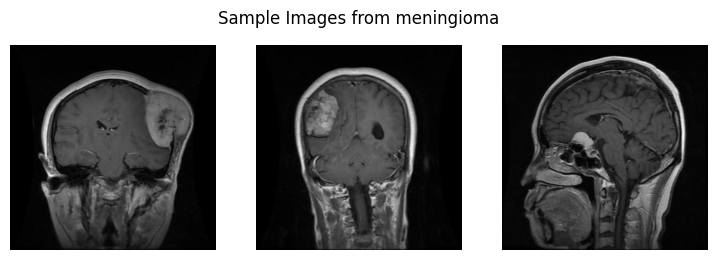

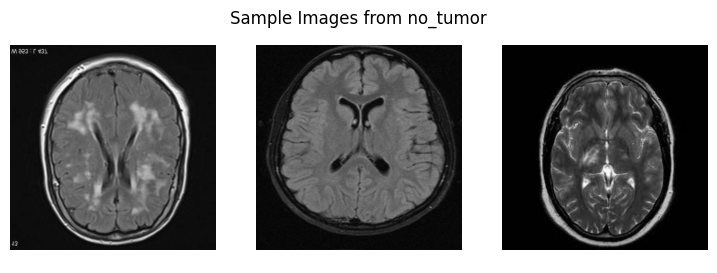

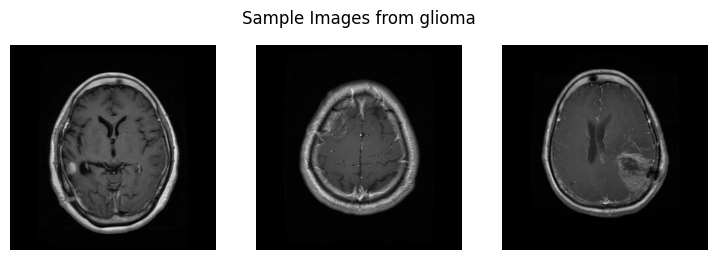

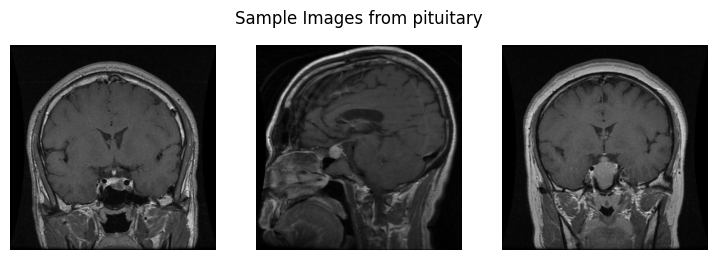


Sample Images from Testing Set


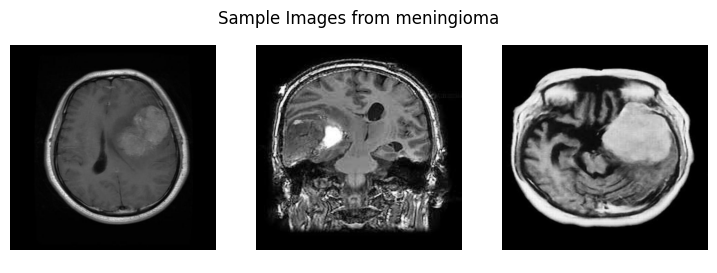

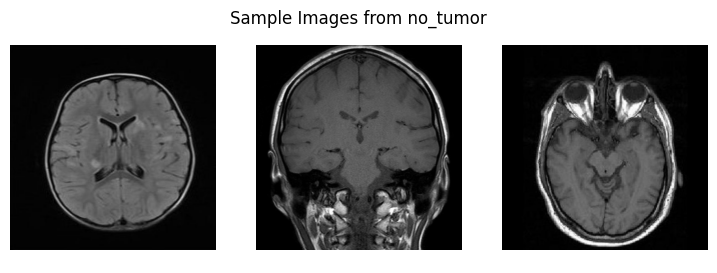

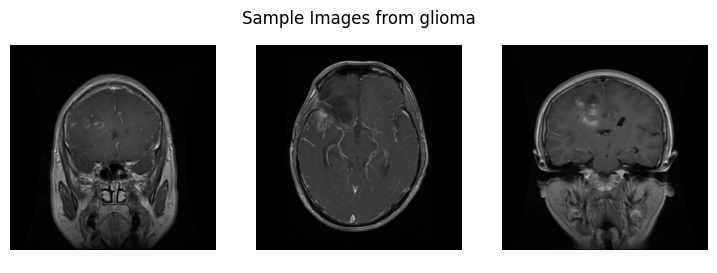

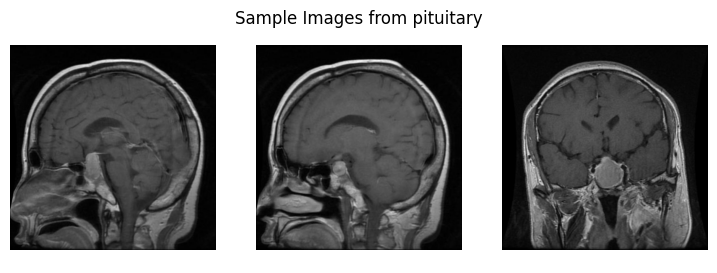


Sample Images from Valid Set


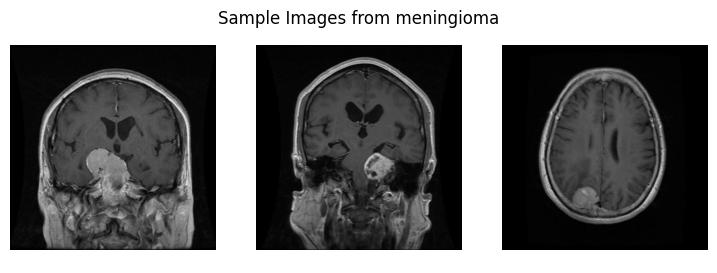

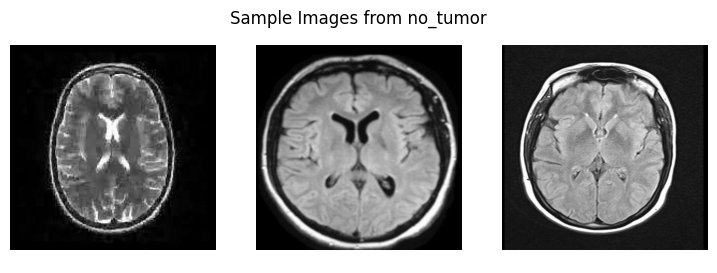

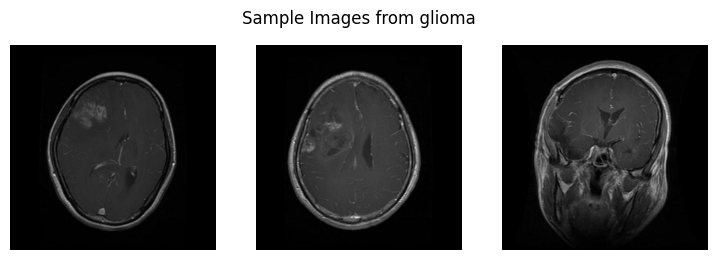

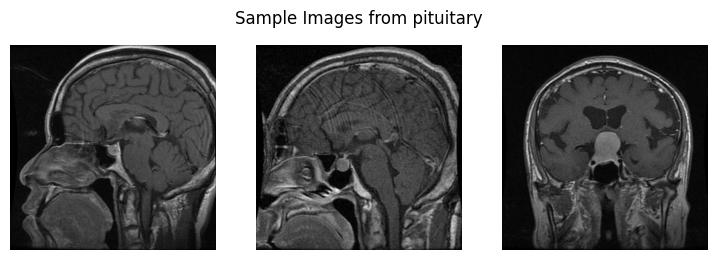

In [164]:
# # First view of dataset
def show_sample_images(data_path,n=3):
    for i in os.listdir(data_path):
        cat_path=os.path.join(data_path,i)
        if(os.path.isdir(cat_path)):
            images=os.listdir(cat_path)[:3]
            plt.figure(figsize=(n*3,3))
            plt.title(f'Sample Images from {i}')
            plt.axis('off')
            for k,j in enumerate(images):
                img=Image.open(os.path.join(cat_path,j))
                plt.subplot(1,n,k+1)
                plt.imshow(img)
                plt.axis('off')
            plt.show()
print("\nSample Images from Training Set")
show_sample_images(train_path)
print("\nSample Images from Testing Set")
show_sample_images(test_path)
print("\nSample Images from Valid Set")
show_sample_images(valid_path)

## Dataset count in each category

In [165]:
def count_dataset(data_path):
    print(f"The dataset has {len(os.listdir(data_path))} folders: {os.listdir(data_path)} \n")
    print("-----------")
    for i in os.listdir(data_path):
        count_cat=0;
        print(f"{i} folder :-")
        if(os.path.isdir(os.path.join(data_path,i))):
            for j in os.listdir(os.path.join(data_path,i)):
                if(os.path.isdir(os.path.join(data_path,i,j))):
                    count_cat+=1
                    print(f"{j} : {len(os.listdir(os.path.join(data_path,i,j)))}")
        print("-----------")


count_dataset(base_path)

The dataset has 3 folders: ['valid', 'train', 'test'] 

-----------
valid folder :-
meningioma : 124
no_tumor : 99
glioma : 161
pituitary : 118
-----------
train folder :-
meningioma : 358
no_tumor : 335
glioma : 564
pituitary : 438
-----------
test folder :-
meningioma : 63
no_tumor : 49
glioma : 80
pituitary : 54
-----------


## Checking class imbalance visually in Training set

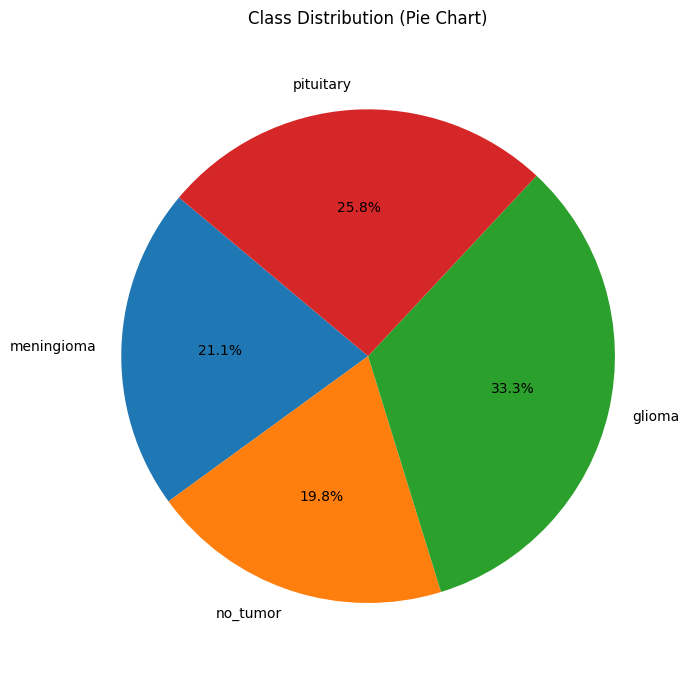

In [166]:
def class_distribution(data_path):
    class_count = {}

    for class_name in os.listdir(data_path):
        class_path = os.path.join(data_path, class_name)
        if os.path.isdir(class_path):
            image_files = os.listdir(class_path)
            class_count[class_name] = len(image_files)

    # Prepare data for pie chart
    labels = [*class_count.keys()]
    sizes = [*class_count.values()]

    # Plot pie chart
    plt.figure(figsize=(7, 7))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140 )
    plt.title("Class Distribution (Pie Chart)")
    plt.axis('equal')  # Equal aspect ratio makes it a circle
    plt.tight_layout()
    plt.show()
class_distribution(train_path)

## Image resolution consistency


Unique Image Resolutions:
(640, 640): 1695 images


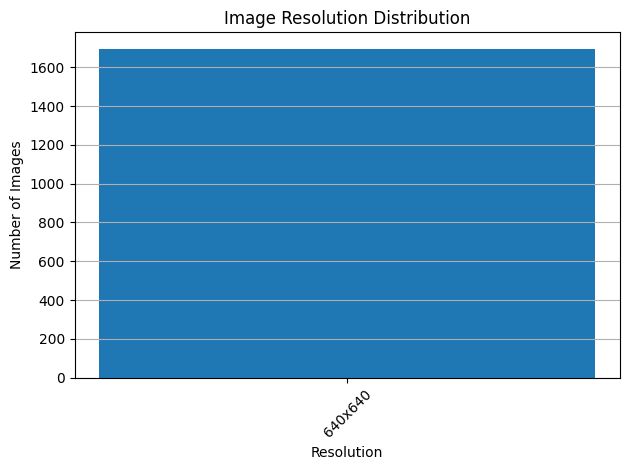

In [167]:
def check_image_resolutions(data_path):
    resolutions = {}

    for folder in os.listdir(data_path):
        path = os.path.join(data_path, folder)
        if not os.path.isdir(path):
            continue

        for file in os.listdir(path):
            try:
                img = Image.open(os.path.join(path, file))
                size = img.size  # (width, height)
                resolutions[size] = resolutions.get(size, 0) + 1
            except:
                print(f"Error reading {file}")

    print("\nUnique Image Resolutions:")
    for res, count in sorted(resolutions.items(), key=lambda x: -x[1]):
        print(f"{res}: {count} images")

    # Plot
    if resolutions:
        labels = [f"{w}x{h}" for (w, h) in resolutions.keys()]
        values = values = [v for v in resolutions.values()]

        plt.bar(labels, values)
        plt.title("Image Resolution Distribution")
        plt.xlabel("Resolution")
        plt.ylabel("Number of Images")
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()
check_image_resolutions(train_path)

## Exploratory Data Analysis

### Univariant Analysis

#### 1. Training Set Class Distribution Bar Graph

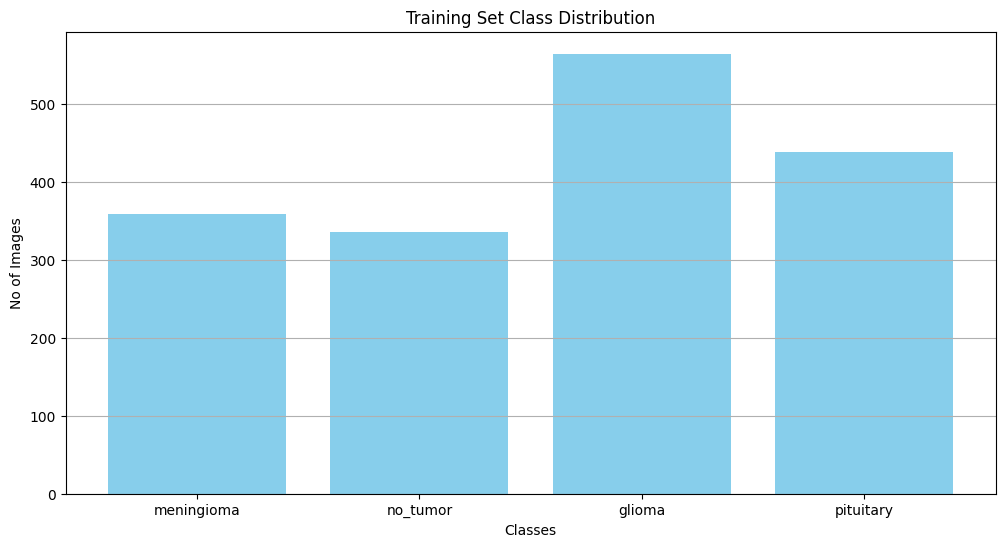

In [168]:
list1=[]
count=[]
for i in os.listdir(train_path):
    if(os.path.isdir(os.path.join(train_path,i))):
        list1.append(i)
        count.append(len(os.listdir(os.path.join(train_path,i))))
plt.figure(figsize=(12,6))
plt.bar(list1,count,color="skyblue")
plt.title("Training Set Class Distribution")
plt.ylabel("No of Images")
plt.xlabel("Classes")
plt.grid(axis='y')
plt.show()

#### 2. Test Set Class Distribution Bar Graph

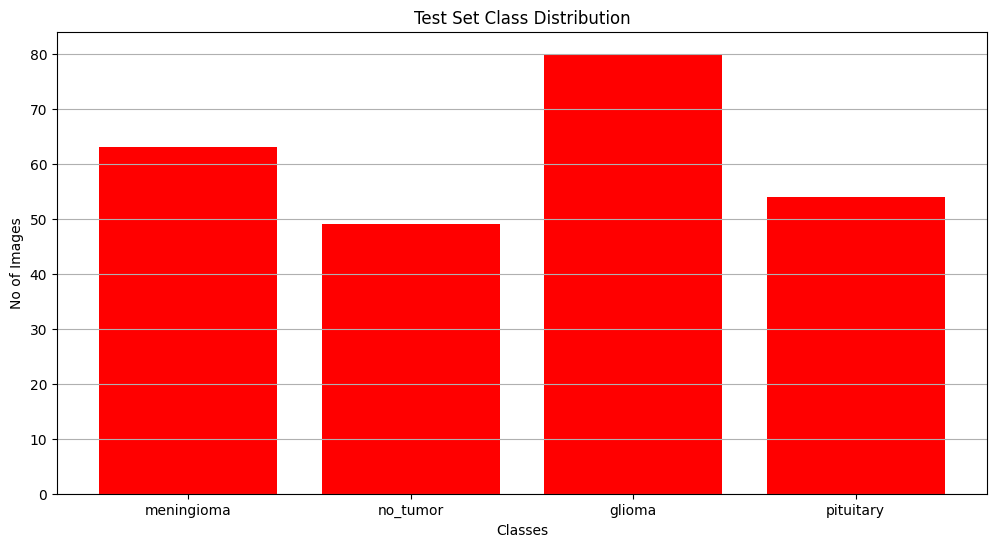

In [169]:
list2=[]
count=[]
for i in os.listdir(test_path):
    if(os.path.isdir(os.path.join(test_path,i))):
        list2.append(i)
        count.append(len(os.listdir(os.path.join(test_path,i))))
plt.figure(figsize=(12,6))
plt.bar(list2,count,color="red")
plt.title("Test Set Class Distribution")
plt.ylabel("No of Images")
plt.xlabel("Classes")
plt.grid(axis='y')
plt.show()

#### 3. Valid Set Class Distribution Bar Graph

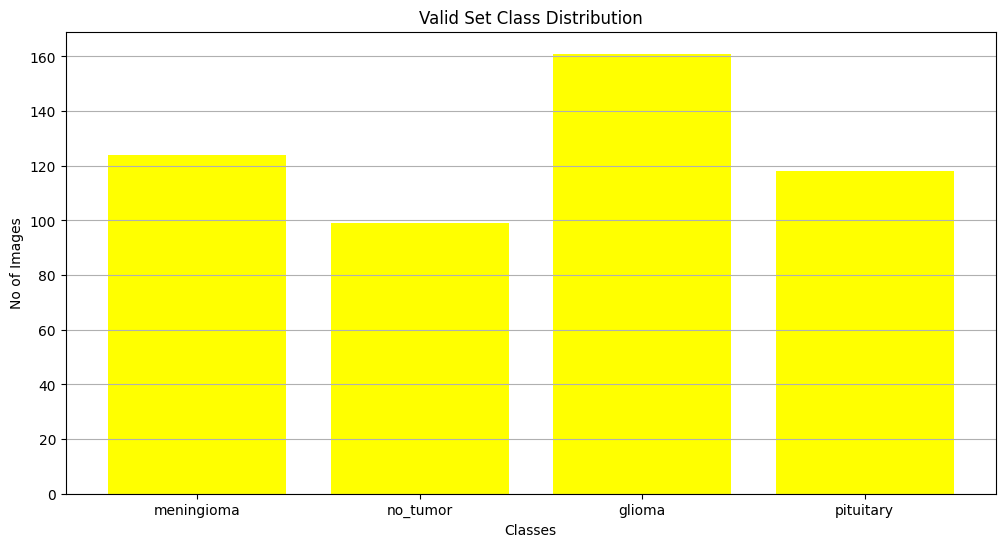

In [170]:
list3=[]
count=[]
for i in os.listdir(valid_path):
    if(os.path.isdir(os.path.join(valid_path,i))):
        list3.append(i)
        count.append(len(os.listdir(os.path.join(valid_path,i))))
plt.figure(figsize=(12,6))
plt.bar(list3,count,color="yellow")
plt.title("Valid Set Class Distribution")
plt.ylabel("No of Images")
plt.xlabel("Classes")
plt.grid(axis='y')
plt.show()

#### 4. Image Resolution Consistency Bar Graph

##### i. Training set


Unique Image Resolutions:
(640, 640): 1695 images


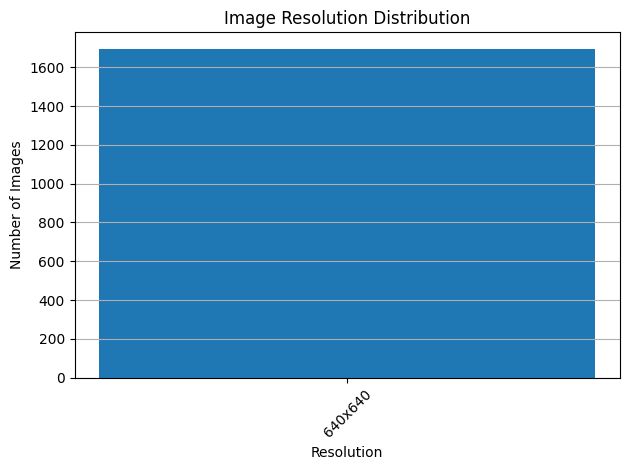

In [171]:
check_image_resolutions(train_path)

##### ii. Testing set


Unique Image Resolutions:
(640, 640): 246 images


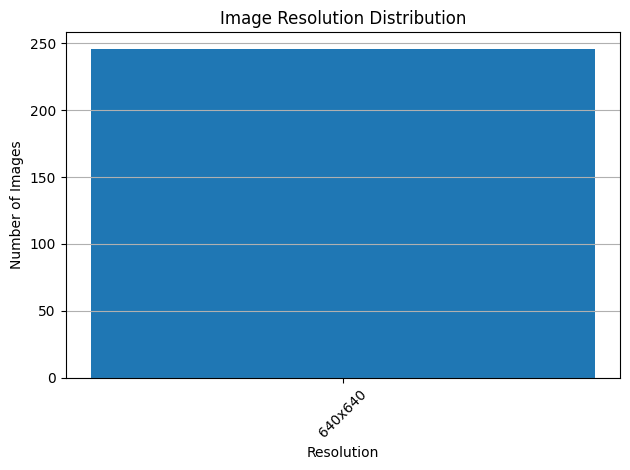

In [172]:
check_image_resolutions(test_path)

#### 3. Brightness distribution Histogram

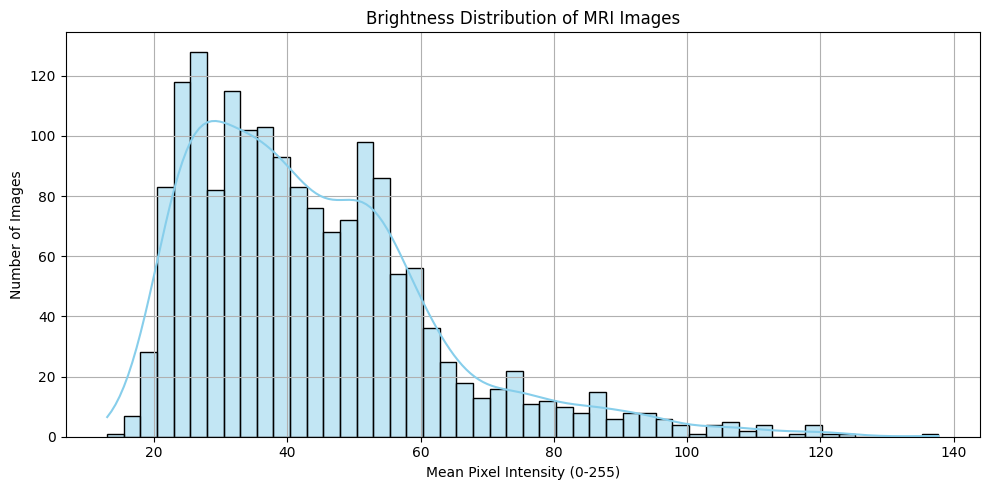

In [173]:
def brightness_dist(data_path):
    brightness_list = []
    warnings.filterwarnings("ignore", category=FutureWarning)

    for i in os.listdir(data_path):
        if os.path.isdir(os.path.join(data_path, i)):
            for j in os.listdir(os.path.join(data_path, i)):
                img = os.path.join(data_path, i, j)
                image = Image.open(img).convert("L")
                img_pix_list = np.array(image)
                mean_brightness = np.mean(img_pix_list)
                brightness_list.append(mean_brightness)

    plt.figure(figsize=(10, 5))
    sns.histplot(brightness_list, bins=50, color='skyblue', kde=True)
    plt.title("Brightness Distribution of MRI Images")
    plt.xlabel("Mean Pixel Intensity (0-255)")
    plt.ylabel("Number of Images")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
brightness_dist(train_path)

#### 4. Pixel Intensity Histogram

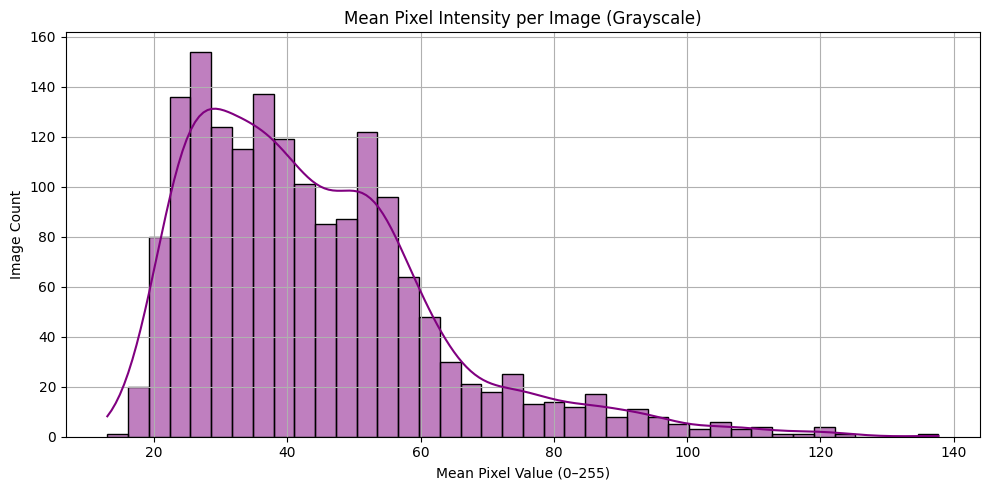

In [174]:
def pixel_intensity_per_image(data_path):
    mean_pixel_values = []

    for class_folder in os.listdir(data_path):
        class_path = os.path.join(data_path, class_folder)
        if not os.path.isdir(class_path): continue

        for image_file in os.listdir(class_path):
            try:
                image_path = os.path.join(class_path, image_file)
                img = Image.open(image_path).convert("L")
                img_arr = np.array(img)
                mean_pixel_values.append(np.mean(img_arr))
            except:
                continue

    plt.figure(figsize=(10, 5))
    sns.histplot(mean_pixel_values, bins=40, kde=True, color="purple")
    plt.title("Mean Pixel Intensity per Image (Grayscale)")
    plt.xlabel("Mean Pixel Value (0–255)")
    plt.ylabel("Image Count")
    plt.tight_layout()
    plt.grid(True)
    plt.show()
pixel_intensity_per_image(train_path)

### Bivariant Analysis

#### 5. Class Count across Folders

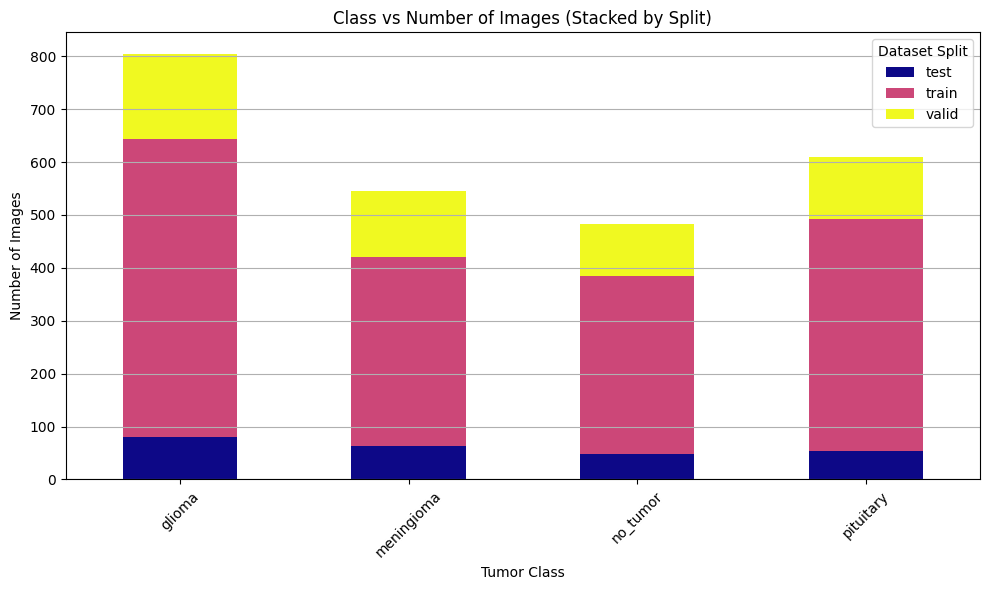

In [175]:
data = []

# Loop through splits and classes
for split in ["train", "valid", "test"]:
    split_path = os.path.join(base_path, split)
    if not os.path.exists(split_path): continue
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        if not os.path.isdir(cls_path): continue
        num_images = len(os.listdir(cls_path))
        data.append({"Class": cls, "Split": split, "ImageCount": num_images})

# Convert to DataFrame
df = pd.DataFrame(data)

# Pivot to wide format for stacked bar
pivot_df = df.pivot(index="Class", columns="Split", values="ImageCount").fillna(0)

# Plot stacked bar
pivot_df.plot(kind="bar", stacked=True, figsize=(10,6), colormap='plasma')
plt.title("Class vs Number of Images (Stacked by Split)")
plt.xlabel("Tumor Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title="Dataset Split")
plt.tight_layout()
plt.show()

#### 6. Class VS Pixel Intensity Boxplot

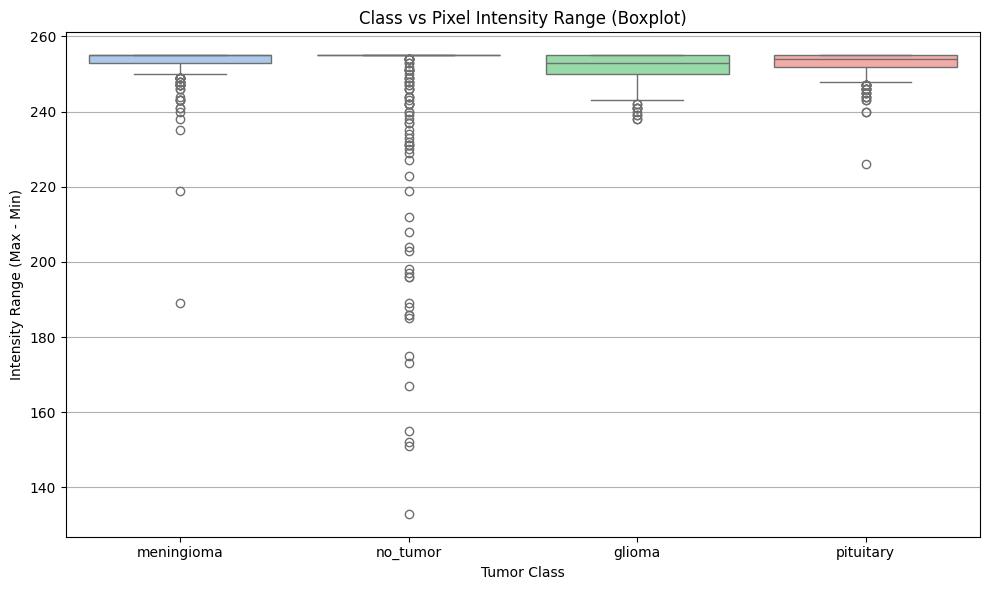

In [176]:
# Build DataFrame with intensity range
data = []
for i in os.listdir(train_path):
    if (os.path.isdir(os.path.join(train_path,i))):
        for j in os.listdir(os.path.join(train_path,i)):
            img=os.path.join(train_path,i,j)
            image=Image.open(img).convert("L")
            img_list=np.array(image)
            intensity_range=np.max(img_list)-np.min(img_list)
            data.append({"class": i, "intensity_range": intensity_range})

df = pd.DataFrame(data)

# Boxplot
plt.figure(figsize=(10,6))
sns.boxplot(x='class', y='intensity_range', data=df, palette='pastel')
plt.title("Class vs Pixel Intensity Range (Boxplot)")
plt.ylabel("Intensity Range (Max - Min)")
plt.xlabel("Tumor Class")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### 7. Class VS brigthness historgram

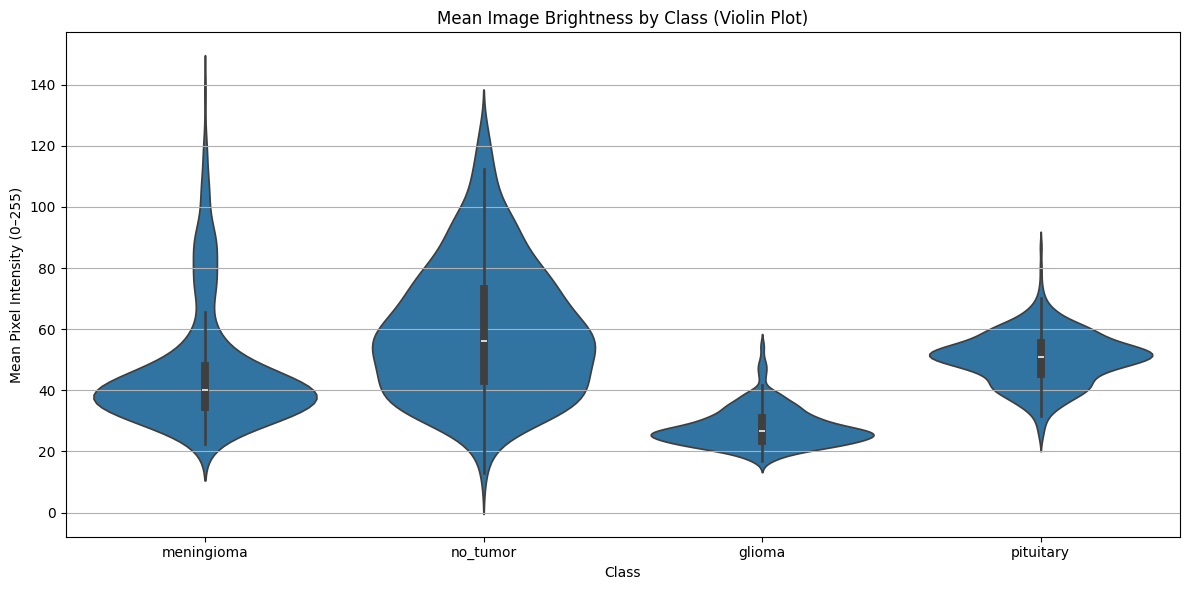

In [177]:
def class_vs_brightness_violin(data_path):
    records = []
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Collect brightness data with class labels
    for class_name in os.listdir(data_path):
        class_folder = os.path.join(data_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                try:
                    image = Image.open(img_path).convert("L")
                    img_pix = np.array(image)
                    mean_brightness = np.mean(img_pix)
                    records.append({"Class": class_name, "Brightness": mean_brightness})
                except Exception as e:
                    continue

    # Create DataFrame for plotting
    df = pd.DataFrame(records)

    # Violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(x="Class", y="Brightness", data=df, inner="box", scale="width")
    plt.title("Mean Image Brightness by Class (Violin Plot)")
    plt.xlabel("Class")
    plt.ylabel("Mean Pixel Intensity (0–255)")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
class_vs_brightness_violin(train_path)

#### 8. Feature Correlation Heatmap

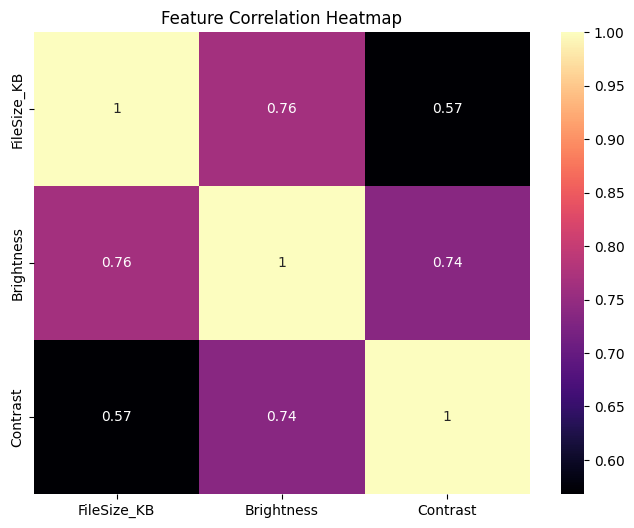

In [178]:
def build_feature_df(data_path):
    records = []
    for class_name in os.listdir(data_path):
        class_folder = os.path.join(data_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                try:
                    image = Image.open(img_path).convert('L')
                    img_array = np.array(image)
                    width, height = image.size
                    file_size_kb = os.path.getsize(img_path)/1024
                    mean_brightness = np.mean(img_array)
                    contrast = np.std(img_array)
                    records.append({
                        'Class': class_name,
                        'Width': width,
                        'Height': height,
                        'FileSize_KB': file_size_kb,
                        'Brightness': mean_brightness,
                        'Contrast': contrast
                    })
                except Exception:
                    continue
    return pd.DataFrame(records)

# Build DataFrame from all images in the dataset
df = build_feature_df(train_path)
# Compute and plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[['FileSize_KB', 'Brightness', 'Contrast']].corr(), annot=True , cmap="magma")
plt.title("Feature Correlation Heatmap")
plt.show()


# **2. Data Augmentation**

In [179]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,             # Normalize pixel values
    rotation_range=20,            # Random rotation (±20 degrees)
    width_shift_range=0.2,        # Horizontal shift up to 20%
    height_shift_range=0.2,       # Vertical shift up to 20%
    zoom_range=0.2,               # Zoom in/out by 20%
    shear_range=0.15,             # Shear intensity
    horizontal_flip=True,         # Randomly flip images horizontally
    brightness_range=[0.8, 1.2],  # Brightness adjustment
    fill_mode='nearest'           # Fill strategy
)

# **3. Creating Data Generators**

In [180]:
# Set seeds
np.random.seed(42)
tf.random.set_seed(42)
img_size = (224, 224)
batch_size = 32
class_names = sorted(os.listdir(train_path))  # auto fetch class folders

valid_test_datagen = ImageDataGenerator(rescale=1. / 255)

print("Creating Data Generators...")
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=True,
    seed=42
)
valid_generator = valid_test_datagen.flow_from_directory(
    valid_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=False
)
test_generator = valid_test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=False
)

print(f"Data Generators Created:")
print(f"-Training samples: {train_generator.samples}")
print(f"-Validation samples: {valid_generator.samples}")
print(f"-Test samples: {test_generator.samples}")
print(f"-Image size: {img_size}")
print(f"-Batch size: {batch_size}")
print(f"-Classes: {train_generator.class_indices}")

Creating Data Generators...
Found 1695 images belonging to 5 classes.
Found 502 images belonging to 5 classes.
Found 246 images belonging to 5 classes.
Data Generators Created:
-Training samples: 1695
-Validation samples: 502
-Test samples: 246
-Image size: (224, 224)
-Batch size: 32
-Classes: {'_classes.csv': 0, 'glioma': 1, 'meningioma': 2, 'no_tumor': 3, 'pituitary': 4}


# **4. Model Building**

## Designing Convolutional Neural Network (CNN)


In [181]:
CNN_model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), padding='same', input_shape=(*img_size, 3),kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), padding='same',kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Block 3
    Conv2D(128, (3, 3), padding='same',kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Fully connected layers
    Flatten(),
    Dense(256,kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(train_generator.num_classes, activation='softmax',kernel_regularizer=l2(0.001))

])

# Compile model
CNN_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Print model summary
CNN_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_300 (Conv2D)             │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_313         │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_310 (Activation)     │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_301 (Conv2D)             │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_314         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_311 (Activation)     │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_302 (Conv2D)             │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_315         │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_312 (Activation)     │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_316         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_313 (Activation)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,786,821 (98.37 MB)

 Trainable params: 25,785,861 (98.37 MB)

 Non-trainable params: 960 (3.75 KB)

# 5. Transfer Learning

In [182]:
def build_transfer_model(base_model_name="ResNet50",
                         input_shape=(224, 224, 3),
                         num_classes=train_generator.num_classes,
                         freeze_all=True,
                         fine_tune_at=None,
                         learning_rate=0.0001):

    # 1. Select base model
    base_model_dict = {
        "ResNet50": ResNet50,
        "MobileNetV2": MobileNetV2,
        "InceptionV3": InceptionV3,
        "EfficientNetB0": EfficientNetB0
    }

    if base_model_name not in base_model_dict:
        raise ValueError(f"Unsupported model name: {base_model_name}. Choose from {list(base_model_dict.keys())}")

    base_model = base_model_dict[base_model_name](
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )

    # 2. Freeze or fine-tune layers
    if freeze_all:
        base_model.trainable = False
    elif fine_tune_at:
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        for layer in base_model.layers[fine_tune_at:]:
            layer.trainable = True
    else:
        base_model.trainable = True  # Fine-tune all layers

    # 3. Add custom head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256,kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax',kernel_regularizer=l2(0.001))(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    # 4. Compile
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

## 1. EfficientNetB0

In [183]:
# Building EfficientNetB0 model
EfficientNetB0_model = build_transfer_model(
    base_model_name="EfficientNetB0",
    input_shape=(224, 224, 3),
    num_classes=train_generator.num_classes,
    freeze_all=True  # Freeze base initially

)

# Print summary
EfficientNetB0_model.summary()


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 224, 224,  │          0 │ input_layer_15[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 224, 224,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 224, 224,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,379,816 (16.71 MB)

 Trainable params: 329,733 (1.26 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

## 2. InceptionV3

In [184]:
# Building InceptionV3 model
InceptionV3_model = build_transfer_model(
    base_model_name="InceptionV3",
    input_shape=(224, 224, 3),
    num_classes=train_generator.num_classes,
    freeze_all=True  # Freeze base initially
)
# Print summary
InceptionV3_model.summary()


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_303 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_16[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_303[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_315      │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_304 (Conv2D) │ (None, 109, 109,  │      9,216 │ activation_315[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_304[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_316      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_305 (Conv2D) │ (None, 109, 109,  │     18,432 │ activation_316[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_305[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_317      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_33    │ (None, 54, 54,    │          0 │ activation_317[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_306 (Conv2D) │ (None, 54, 54,    │      5,120 │ max_pooling2d_33… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_306[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_318      │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_307 (Conv2D) │ (None, 52, 52,    │    138,240 │ activation_318[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_307[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_319      │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,329,637 (85.18 MB)

 Trainable params: 526,341 (2.01 MB)

 Non-trainable params: 21,803,296 (83.17 MB)

## 3. ResNet50

In [185]:
# Building InceptionV3 model
ResNet50_model = build_transfer_model(
    base_model_name="ResNet50",
    input_shape=(224, 224, 3),
    num_classes=train_generator.num_classes,
    freeze_all=True  # Freeze base initially
)
# Print summary
ResNet50_model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_17[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,565 (91.99 MB)

 Trainable params: 526,341 (2.01 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

# 6. Model Training

## 1. Training Model

In [189]:
def train_model(model, model_name, train_generator, valid_generator, epochs=30):
    print(f"\n Training model: {model_name}")

    # Extract class labels from generator
    y_train_labels = train_generator.classes

    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_labels),
        y=y_train_labels
    )
    class_weights = dict(enumerate(class_weights))

    # Define callbacks
    checkpoint = ModelCheckpoint(f"{model_name}_best_model.h5",
                                 monitor='val_loss',
                                 save_best_only=True,
                                 verbose=1)
    early_stop = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True,
                               verbose=1)

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=epochs,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint]
    )
    return history


In [190]:
import os
from collections import Counter

labels = []
for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    if os.path.isdir(folder_path):
        count = len(os.listdir(folder_path))
        labels.extend([folder] * count)

print(Counter(labels))


Counter({'glioma': 564, 'pituitary': 438, 'meningioma': 358, 'no_tumor': 335})


In [191]:
warnings.filterwarnings("ignore", category=UserWarning)
# Train custom CNN
cnn_history = train_model(CNN_model, "CustomCNN", train_generator, valid_generator)
# Train EfficientNetB0
effnet_history = train_model(EfficientNetB0_model, "EfficientNetB0", train_generator, valid_generator)
# Train InceptionV3
inception_history = train_model(InceptionV3_model, "InceptionV3", train_generator, valid_generator)
# Train ResNet50
resnet_history = train_model(ResNet50_model, "ResNet50", train_generator, valid_generator)


 Training model: CustomCNN
Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4833 - loss: 1.6885
Epoch 1: val_loss improved from inf to 1.87510, saving model to CustomCNN_best_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 377s 7s/step - accuracy: 0.4843 - loss: 1.6861 - val_accuracy: 0.3685 - val_loss: 1.8751
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5763 - loss: 1.3616
Epoch 2: val_loss improved from 1.87510 to 1.81763, saving model to CustomCNN_best_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 363s 7s/step - accuracy: 0.5764 - loss: 1.3611 - val_accuracy: 0.2351 - val_loss: 1.8176
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6122 - loss: 1.2255
Epoch 3: val_loss improved from 1.81763 to 1.71494, saving model to CustomCNN_best_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 377s 7s/step - accuracy: 0.6122 - loss: 1.2252 - val_accuracy: 0.2351 - val_loss: 1.7149
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6337 - loss: 1.1640
Epoch 4: val_loss improved from 1.71494 to 1.69229, saving model to CustomCNN_best_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 371s 7s/step - accuracy: 0.6335 - loss: 1.1638 - val_accuracy: 0.2351 - val_loss: 1.6923
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6300 - loss: 1.1395
Epoch 5: val_loss improved from 1.69229 to 1.54857, saving model to CustomCNN_best_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 375s 7s/step - accuracy: 0.6300 - loss: 1.1395 - val_accuracy: 0.4104 - val_loss: 1.5486
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6578 - loss: 1.0769
Epoch 6: val_loss did not improve from 1.54857
53/53 ━━━━━━━━━━━━━━━━━━━━ 366s 7s/step - accuracy: 0.6576 - loss: 1.0766 - val_accuracy: 0.2789 - val_loss: 1.6118
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6542 - loss: 0.9619
Epoch 7: val_loss did not improve from 1.54857
53/53 ━━━━━━━━━━━━━━━━━━━━ 372s 7s/step - accuracy: 0.6545 - loss: 0.9623 - val_accuracy: 0.2530 - val_loss: 1.6872
Epoch 8/30
 2/53 ━━━━━━━━━━━━━━━━━━━━ 4:59 6s/step - accuracy: 0.6484 - loss: 0.9605

KeyboardInterrupt: 

## Fine-Tuning After Initial Training

In [ ]:
def fine_tune_model(model, base_model_name, unfreeze_at=-20, learning_rate=1e-5):
    print(f"\n Fine-tuning {base_model_name} from layer {unfreeze_at} onward...")

    base_model = model.layers[0]  # first layer is base_model

    for layer in base_model.layers[:unfreeze_at]:
        layer.trainable = False
    for layer in base_model.layers[unfreeze_at:]:
        layer.trainable = True

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


## 2. Visualizing Accuracy and Loss

In [ ]:
def plot_training_history(histories):
    for model_name, history in histories.items():
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs_range = range(1, len(acc) + 1)

        plt.figure(figsize=(14, 5))

        # Accuracy Plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.title(f'{model_name} - Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss Plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.title(f'{model_name} - Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.suptitle(f"Training History for {model_name}", fontsize=16)
        plt.tight_layout()
        plt.show()
plot_training_history(histories)

# 7. Model Evaluation

## 1. Evaluating Model Using :

* Accuracy Score
* Precision Score
* Recall Score
* F1 Score
* Confusion Matrix

In [ ]:
def evaluate_model(model, valid_generator, class_names, model_name="Model"):
    print("-----------------------------")
    print(f"\n Evaluating: {model_name}")

    # Get true labels
    true_labels = valid_generator.classes

    # Get predicted probabilities
    pred_probs = model.predict(valid_generator, verbose=1)

    # Get predicted class indices
    pred_labels = np.argmax(pred_probs, axis=1)

    # Accuracy
    acc = accuracy_score(true_labels, pred_labels)
    prec = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    rec = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)

    # Classification Report
    print(f"\n Classification Report:\n{classification_report(true_labels, pred_labels, target_names=class_names)}")

    # Confusion Matrix
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1
    }

In [ ]:
class_names = list(valid_generator.class_indices.keys())
results = {}

for name, model in models.items():
    model.load_weights(f"/kaggle/working/{name}_best_model.keras")  # load best checkpoint
    results[name] = evaluate_model(model, valid_generator, class_names, name)

In [ ]:
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)
print("\n Model Performance Comparison:")
display(results_df)

accuracy vs loss

In [ ]:
def plot_metric(histories, metric='accuracy'):
    plt.figure(figsize=(16, 6))
    for name, history in histories.items():
        plt.plot(history.history[metric], label=f"{name} - train")
        plt.plot(history.history[f"val_{metric}"], label=f"{name} - val", linestyle='-')
    plt.title(f'{metric.capitalize()} Comparison')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric(histories, 'accuracy')
plot_metric(histories, 'loss')

# 8. Model Comparison

## 1.  Evaluating Each Model Based on the Test Set

In [ ]:
def evaluate_model(name, model, test_generator):
    print(f"\n Evaluation Results for: {name}")

    # Get true labels and predictions
    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Classification report
    print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    plt.title(f'{name} - Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
for name, model in models.items():
    evaluate_model(name, model, valid_generator)


## 2. Metric Summary

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Define the model comparison data
data = {
    'Metric': ['Starting Accuracy', 'Final Val Accuracy', 'Loss Behavior', 'Overfitting', 'Ease of Tuning'],
    'CustomCNN': ['0.38', '~0.55', 'Exploding', 'Yes', 'Hard'],
    'EfficientNetB0': ['0.28', '~0.56', 'High but stable', 'Moderate', 'Medium'],
    'InceptionV3': ['0.39', '0.89 ✅', 'Stable & low ✅', 'No ✅', 'Easy ✅']
}

# Create DataFrame
df = pd.DataFrame(data)

# Display the table
print("\nModel Comparison Table:\n")
print(df.to_string(index=False))

# Convert accuracies to float for plotting
plot_data = {
    'Model': ['CustomCNN', 'EfficientNetB0', 'InceptionV3'],
    'Starting Accuracy': [0.38, 0.28, 0.39],
    'Final Val Accuracy': [0.55, 0.56, 0.89]
}

plot_df = pd.DataFrame(plot_data)

# Melt the DataFrame for seaborn barplot
melted_df = pd.melt(plot_df, id_vars='Model', var_name='Accuracy Type', value_name='Accuracy')

# Plot barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', hue='Accuracy Type', data=melted_df, palette='Set2')
plt.title('Starting vs Final Validation Accuracy of Models')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [ ]:
def get_metrics(model, test_generator):
    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='weighted'),
        "Recall": recall_score(y_true, y_pred, average='weighted'),
        "F1-score": f1_score(y_true, y_pred, average='weighted')
    }

# Collect results
results = {}
for name, model in models.items():
    results[name] = get_metrics(model, valid_generator)

# Convert to DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)
results_df

In [ ]:

summary = {
    "Model": [],
    "Start_Accuracy": [],
    "Final_Val_Accuracy": [],
    "Final_Train_Accuracy": [],
    "Final_Val_Loss": [],
    "Final_Train_Loss": [],
    "Overfitting": [],
    "Ease_of_Tuning": []
}

for name, history in histories.items():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    summary["Model"].append(name)
    summary["Start_Accuracy"].append(round(acc[0], 4))
    summary["Final_Train_Accuracy"].append(round(acc[-1], 4))
    summary["Final_Val_Accuracy"].append(round(val_acc[-1], 4))
    summary["Final_Train_Loss"].append(round(loss[-1], 4))
    summary["Final_Val_Loss"].append(round(val_loss[-1], 4))

    # Overfitting score (higher = more overfitting)
    overfit = round((acc[-1] - val_acc[-1]) + (val_loss[-1] - loss[-1]), 4)
    summary["Overfitting"].append(overfit)

    # Ease of tuning (subjective)
    if name == "CustomCNN":
        ease = "High"
    elif "EfficientNet" in name:
        ease = "Medium"
    elif "Inception" in name:
        ease = "Low"
    else:
        ease = "Medium"
    summary["Ease_of_Tuning"].append(ease)

df_summary = pd.DataFrame(summary).transpose()
df_summary


## 3. Visualization of the Comparison

In [ ]:
results_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Comparison on Validation Set")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.ylim(0, 1)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()